In [28]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [3]:
vaccine_data = pd.read_csv("https://api.covid19india.org/csv/latest/cowin_vaccine_data_statewise.csv")

In [4]:
vaccine_data.head(5)

,Updated On,State,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,Total Sputnik V Administered,AEFI,18-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,23757.0,24517.0,2.0,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,48276.0
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,27348.0,31252.0,4.0,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,58604.0
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,41361.0,58083.0,5.0,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,99449.0
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,81901.0,113613.0,11.0,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,195525.0
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,98111.0,153145.0,24.0,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,251280.0


In [63]:
india_map = geopandas.read_file("India-State-and-Country-Shapefile-Updated-Jan-2020/India_State_Boundary.shp")
india_map.loc[india_map['State_Name']=='Chhattishgarh','State_Name'] = "Chhattisgarh"
india_map.loc[india_map['State_Name']=='Daman and Diu and Dadra and Nagar Haveli','State_Name'] = "Dadra and Nagar Haveli and Daman and Diu"
india_map.loc[india_map['State_Name']=='Andaman & Nicobar','State_Name'] = "Andaman and Nicobar Islands"
india_map.loc[india_map['State_Name']=='Tamilnadu','State_Name'] = "Tamil Nadu"
india_map.loc[india_map['State_Name']=='Telengana','State_Name'] = "Telangana"
india_map

,State_Name,geometry
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
1,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400..."
2,Dadra and Nagar Haveli and Daman and Diu,"MULTIPOLYGON (((8122247.822 2312434.407, 81223..."
3,Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212..."
4,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392..."
5,Jharkhand,"POLYGON ((9762288.285 2772949.712, 9762301.816..."
6,Karnataka,"MULTIPOLYGON (((8608594.474 2090389.205, 86086..."
7,Kerala,"POLYGON ((8347733.191 1436381.747, 8347795.745..."
8,Lakshadweep,"MULTIPOLYGON (((8135256.290 930182.487, 813526..."
9,Madhya Pradesh,"POLYGON ((8724343.278 3106498.184, 8724579.382..."


<AxesSubplot:>

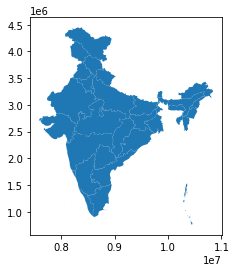

In [21]:
india_map.plot()

In [24]:
present_state = vaccine_data.loc[vaccine_data['Updated On']=='10/06/2021']

In [25]:
present_state

,Updated On,State,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,Total Sputnik V Administered,AEFI,18-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
145,10/06/2021,India,195747476.0,12035310.0,42414.0,195747476.0,46099387.0,105607170.0,90106724.0,33582.0,28814428.0,213010415.0,22020.0,21991.0,53072899.0,80018155.0,62574015.0,241846863.0
299,10/06/2021,Andaman and Nicobar Islands,114098.0,2546.0,13.0,114098.0,15304.0,61439.0,52650.0,9.0,0.0,129402.0,0.0,3.0,22365.0,60971.0,30759.0,129402.0
453,10/06/2021,Andhra Pradesh,8891341.0,810123.0,1567.0,8891341.0,2605099.0,4452456.0,4437458.0,1427.0,2059722.0,9432881.0,3837.0,330.0,1450753.0,4591810.0,2847057.0,11496440.0
607,10/06/2021,Arunachal Pradesh,321736.0,16899.0,110.0,321736.0,78912.0,177424.0,144199.0,113.0,0.0,400648.0,0.0,271.0,143437.0,128515.0,49733.0,400648.0
761,10/06/2021,Assam,3695526.0,210842.0,1061.0,3695526.0,890228.0,2002615.0,1692300.0,611.0,885083.0,3700671.0,0.0,183.0,1153217.0,1678565.0,863347.0,4585754.0
915,10/06/2021,Bihar,9712352.0,954916.0,2934.0,9712352.0,1887467.0,5378257.0,4332166.0,1929.0,1053972.0,10545847.0,0.0,197.0,3050937.0,3256472.0,3401588.0,11599819.0
1069,10/06/2021,Chandigarh,314057.0,12357.0,57.0,314057.0,75514.0,177025.0,136987.0,45.0,0.0,389571.0,0.0,138.0,112479.0,123426.0,78019.0,389571.0
1223,10/06/2021,Chhattisgarh,5162838.0,266438.0,1365.0,5162838.0,1148479.0,2524464.0,2637798.0,576.0,218061.0,6093256.0,0.0,564.0,467230.0,2941979.0,1753265.0,6311317.0
1377,10/06/2021,Dadra and Nagar Haveli and Daman and Diu,218904.0,17855.0,74.0,218904.0,26196.0,141277.0,77585.0,42.0,0.0,245100.0,0.0,87.0,141038.0,56715.0,21024.0,245100.0
1531,10/06/2021,Delhi,4521905.0,226438.0,1133.0,4521905.0,1394373.0,2625225.0,1895772.0,908.0,1811475.0,4104803.0,0.0,955.0,1756814.0,1716199.0,1045124.0,5916278.0


In [26]:
india_map.head()

,State_Name,geometry
0,Andaman & Nicobar,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
1,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400..."
2,Daman and Diu and Dadra and Nagar Haveli,"MULTIPOLYGON (((8122247.822 2312434.407, 81223..."
3,Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212..."
4,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392..."


In [64]:
merged_map = india_map.set_index('State_Name').join(present_state.set_index('State'))

In [65]:
merged_map

,geometry,Updated On,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,Total Sputnik V Administered,AEFI,18-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
Andaman and Nicobar Islands,"MULTIPOLYGON (((10341718.474 1449533.161, 1034...",10/06/2021,114098.0,2546.0,13.0,114098.0,15304.0,61439.0,52650.0,9.0,0.0,129402.0,0.0,3.0,22365.0,60971.0,30759.0,129402.0
Andhra Pradesh,"POLYGON ((9426056.496 2174632.352, 9426228.484...",10/06/2021,8891341.0,810123.0,1567.0,8891341.0,2605099.0,4452456.0,4437458.0,1427.0,2059722.0,9432881.0,3837.0,330.0,1450753.0,4591810.0,2847057.0,11496440.0
Arunachal Pradesh,"POLYGON ((10696175.277 3434232.650, 10696981.8...",10/06/2021,321736.0,16899.0,110.0,321736.0,78912.0,177424.0,144199.0,113.0,0.0,400648.0,0.0,271.0,143437.0,128515.0,49733.0,400648.0
Assam,"POLYGON ((10380499.251 2872443.723, 10380499.2...",10/06/2021,3695526.0,210842.0,1061.0,3695526.0,890228.0,2002615.0,1692300.0,611.0,885083.0,3700671.0,0.0,183.0,1153217.0,1678565.0,863347.0,4585754.0
Bihar,"POLYGON ((9362949.333 3188807.607, 9362966.106...",10/06/2021,9712352.0,954916.0,2934.0,9712352.0,1887467.0,5378257.0,4332166.0,1929.0,1053972.0,10545847.0,0.0,197.0,3050937.0,3256472.0,3401588.0,11599819.0
Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400...",10/06/2021,314057.0,12357.0,57.0,314057.0,75514.0,177025.0,136987.0,45.0,0.0,389571.0,0.0,138.0,112479.0,123426.0,78019.0,389571.0
Chhattisgarh,"POLYGON ((9275926.808 2765881.317, 9276185.437...",10/06/2021,5162838.0,266438.0,1365.0,5162838.0,1148479.0,2524464.0,2637798.0,576.0,218061.0,6093256.0,0.0,564.0,467230.0,2941979.0,1753265.0,6311317.0
Dadra and Nagar Haveli and Daman and Diu,"MULTIPOLYGON (((8122247.822 2312434.407, 81223...",10/06/2021,218904.0,17855.0,74.0,218904.0,26196.0,141277.0,77585.0,42.0,0.0,245100.0,0.0,87.0,141038.0,56715.0,21024.0,245100.0
Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212...",10/06/2021,4521905.0,226438.0,1133.0,4521905.0,1394373.0,2625225.0,1895772.0,908.0,1811475.0,4104803.0,0.0,955.0,1756814.0,1716199.0,1045124.0,5916278.0
Goa,"POLYGON ((8223217.424 1779394.764, 8223279.301...",10/06/2021,511379.0,30166.0,86.0,511379.0,97185.0,261168.0,250167.0,44.0,11064.0,597500.0,0.0,573.0,164955.0,192877.0,153478.0,608564.0


(7420514.3854749985, 11006384.850025, 568656.3556074101, 4637589.076044399)

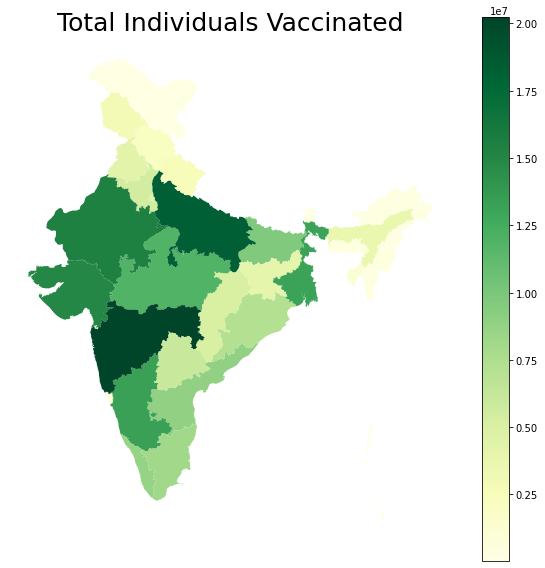

In [70]:
fig, ax = plt.subplots(1,figsize=(10,10))
merged_map.plot(column='Total Individuals Vaccinated', cmap='YlGn', ax=ax, legend=True)
ax.set_title('Total Individuals Vaccinated', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.axis('off')

In [47]:
merged_map[]

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>